In [35]:
from importlib.metadata import version

## 当前代码需要用到的包
pkgs = ['datasets', 'sentence_transformers', 'umap-learn', 'hdbscan', 'bertopic']

for pkg in pkgs:
    print(f"{pkg}:", version(pkg))


import os
os.environ['HF_ENDPOINT'] = "https://hf-mirror.com"
os.environ['TRANSFORMERS_CACHE'] = "/root/autodl-tmp/LLMs/.cache/huggingface"
os.environ['HF_HOME'] = "/root/autodl-tmp/LLMs/.cache/huggingface"

import subprocess

result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
output = result.stdout
for line in output.splitlines():
    if '=' in line:
        var, value = line.split('=', 1)
        os.environ[var] = value

datasets: 4.0.0
sentence_transformers: 5.1.0
umap-learn: 0.5.9.post2
hdbscan: 0.8.40
bertopic: 0.17.3


# Load dataset and embedings

In [2]:
# load dataset
from datasets import load_dataset
dataset = load_dataset("maartengr/arxiv_nlp")['train']

# Extract metadata
abstracts = dataset['Abstracts']
titles = dataset['Titles']

In [3]:
print(f'Title: {titles[0]}')
print(f'Abstract: {abstracts[0]}')

Title: Introduction to Arabic Speech Recognition Using CMUSphinx System
Abstract:   In this paper Arabic was investigated from the speech recognition problem
point of view. We propose a novel approach to build an Arabic Automated Speech
Recognition System (ASR). This system is based on the open source CMU Sphinx-4,
from the Carnegie Mellon University. CMU Sphinx is a large-vocabulary;
speaker-independent, continuous speech recognition system based on discrete
Hidden Markov Models (HMMs). We build a model using utilities from the
OpenSource CMU Sphinx. We will demonstrate the possible adaptability of this
system to Arabic voice recognition.



In [4]:
from sentence_transformers import SentenceTransformer

# create embeddings of abstracts
embedding_model = SentenceTransformer("thenlper/gte-small")
embeddings = embedding_model.encode(abstracts, show_progress_bar=True)

# show the dim of embeddings of abstracts
embeddings.shape

/root/miniconda3/lib/python3.12/site-packages/transformers/utils/hub.py:111: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


Batches:   0%|          | 0/1405 [00:00<?, ?it/s]

(44949, 384)

# Text Clustering

## Reducing the Dimensionality of Embeddings

In [5]:
from umap import UMAP

# reduce dim from 384 to 5
umap_model = UMAP(
    n_components=5, min_dist=0.0, metric='cosine', random_state=42
)
reduced_embeddings = umap_model.fit_transform(embeddings)

/root/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/root/miniconda3/lib/python3.12/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


In [7]:
reduced_embeddings.shape

(44949, 5)

## Cluster the Reduced Embeddings

In [12]:
from hdbscan import HDBSCAN

# fit the model and extract the clusters
hdbscan_model = HDBSCAN(
    min_cluster_size=50, metric='euclidean', cluster_selection_method='eom'
).fit(reduced_embeddings)
clusters = hdbscan_model.labels_

print(f'# of clusters: {len(set(clusters))}')

/root/miniconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


# of clusters: 155


## Inspecting the Clusters

In [27]:
import numpy as np

cluster = 0
for index in np.where(clusters==cluster)[0][:3]:
    print(abstracts[int(index)][:300] + "... \n")

  This works aims to design a statistical machine translation from English text
to American Sign Language (ASL). The system is based on Moses tool with some
modifications and the results are synthesized through a 3D avatar for
interpretation. First, we translate the input text to gloss, a written fo... 

  Researches on signed languages still strongly dissociate lin- guistic issues
related on phonological and phonetic aspects, and gesture studies for
recognition and synthesis purposes. This paper focuses on the imbrication of
motion and meaning for the analysis, synthesis and evaluation of sign lang... 

  Modern computational linguistic software cannot produce important aspects of
sign language translation. Using some researches we deduce that the majority of
automatic sign language translation systems ignore many aspects when they
generate animation; therefore the interpretation lost the truth inf... 



In [29]:
import pandas as pd

# continue reduce dim from 384 to 2
reduced_embeddings = UMAP(
    n_components=2, min_dist=0.0, metric='cosine', random_state=42
).fit_transform(embeddings)

# create dataframe
df = pd.DataFrame(reduced_embeddings, columns=['x', 'y'])
df['title'] = titles
df['cluster'] = [str(c) for c in clusters]

to_plots = df.loc[df.cluster != "-1", :]
outliers = df.loc[df.cluster == "-1", :]

/root/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [31]:
to_plots.head()

,x,y,title,cluster
4,4.513205,2.437404,Segmentation and Context of Literary and Music...,85
5,3.366080,0.421517,International Standard for a Linguistic Annota...,97
6,3.342744,0.499340,A Formal Model of Dictionary Structure and Con...,97
8,3.254276,1.290046,Learning Probabilistic Models of Word Sense Di...,101
11,-1.310467,-0.201164,Bio-linguistic transition and Baldwin effect i...,90


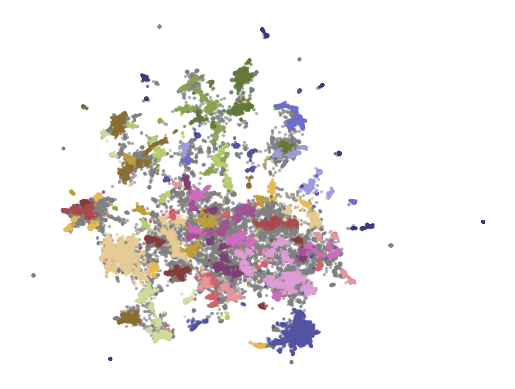

In [34]:
import matplotlib.pyplot as plt

plt.scatter(outliers.x, outliers.y, alpha=0.5, s=2, c='grey')
plt.scatter(to_plots.x, to_plots.y, c=to_plots.cluster.astype(int), alpha=0.6, s=2, cmap='tab20b')
plt.axis("off")
plt.show()

# Topic Modeling

### Using BERTopic

In [36]:
from bertopic import BERTopic

# train the model with previously defined models
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    verbose=True
).fit(abstracts, embeddings)

2025-08-27 22:10:29,548 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-08-27 22:11:20,206 - BERTopic - Dimensionality - Completed ✓
2025-08-27 22:11:20,211 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-08-27 22:11:22,756 - BERTopic - Cluster - Completed ✓
2025-08-27 22:11:22,772 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-27 22:11:26,608 - BERTopic - Representation - Completed ✓


In [37]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,14210,-1_of_the_and_to,"[of, the, and, to, in, we, language, for, that...",[ GPT-$3$ has attracted lots of attention due...
1,0,2316,0_speech_asr_recognition_end,"[speech, asr, recognition, end, acoustic, spea...",[ The speech chain mechanism integrates autom...
2,1,2183,1_question_qa_questions_answer,"[question, qa, questions, answer, answering, a...",[ Text-based Question Generation (QG) aims at...
3,2,941,2_translation_nmt_machine_bleu,"[translation, nmt, machine, bleu, neural, engl...","[ Recently, the development of neural machine..."
4,3,880,3_summarization_summaries_summary_abstractive,"[summarization, summaries, summary, abstractiv...",[ Sentence summarization shortens given texts...
...,...,...,...,...,...
150,149,54,149_sentence_embeddings_sts_embedding,"[sentence, embeddings, sts, embedding, similar...",[ Sentence representation at the semantic lev...
151,150,54,150_gans_gan_adversarial_generation,"[gans, gan, adversarial, generation, generativ...",[ Text generation is of particular interest i...
152,151,54,151_coherence_discourse_paragraph_text,"[coherence, discourse, paragraph, text, cohesi...",[ While there has been significant progress t...
153,152,53,152_chatgpt_its_openai_tasks,"[chatgpt, its, openai, tasks, has, ai, capabil...","[ Over the last few years, large language mod..."


In [38]:
topic_model.get_topic(0)

[('speech', np.float64(0.028208883288593535)),
 ('asr', np.float64(0.018842312810416793)),
 ('recognition', np.float64(0.01351959051292077)),
 ('end', np.float64(0.009745990895354896)),
 ('acoustic', np.float64(0.009384710004108402)),
 ('speaker', np.float64(0.006877359138616964)),
 ('audio', np.float64(0.006785262733110495)),
 ('the', np.float64(0.006370412745274845)),
 ('error', np.float64(0.00634287314665723)),
 ('automatic', np.float64(0.0063065026437668335))]

In [39]:
topic_model.find_topics("topic modeling")

([24, -1, 38, 32, 84],
 [np.float32(0.9545274),
  np.float32(0.9123676),
  np.float32(0.9080541),
  np.float32(0.9053283),
  np.float32(0.90453553)])

In [41]:
topic_model.get_topic(24)

[('topic', np.float64(0.06811153301756999)),
 ('topics', np.float64(0.035746717561104396)),
 ('lda', np.float64(0.016020062969070364)),
 ('latent', np.float64(0.013574936227317968)),
 ('documents', np.float64(0.013201698266173009)),
 ('document', np.float64(0.012912590658853182)),
 ('modeling', np.float64(0.012084716289729468)),
 ('dirichlet', np.float64(0.01010281253111858)),
 ('word', np.float64(0.008653858081603273)),
 ('allocation', np.float64(0.007950503995528465))]

### Adding a Special Lego Block

In [47]:
def topic_differences(model, original_topics, nr_topics=5):
    df = pd.DataFrame(columns=['Topic', 'Original', 'Updated'])
    for topic in range(nr_topics):
        og_words = " | ".join(list(zip(*original_topics[topic]))[0][:5])
        new_words = " | ".join(list(zip(*model.get_topic(topic)))[0][:5])
        df.loc[len(df)] = [topic, og_words, new_words]
    return df

In [49]:
from copy import deepcopy
original_topics = deepcopy(topic_model.topic_representations_)

#### KeyBERTInspired

In [50]:
from bertopic.representation import KeyBERTInspired

representation_model = KeyBERTInspired()
topic_model.update_topics(abstracts, representation_model=representation_model)

topic_differences(topic_model, original_topics)

,Topic,Original,Updated
0,0,phonetic | encoder | transcription | speech | ...,phonetic | encoder | transcription | speech | ...
1,1,answering | comprehension | questions | questi...,answering | comprehension | questions | questi...
2,2,translation | translate | translations | trans...,translation | translate | translations | trans...
3,3,summarization | summarizers | summaries | summ...,summarization | summarizers | summaries | summ...
4,4,hate | hateful | language | offensive | languages,hate | hateful | language | offensive | languages


#### MaximalMarginalRelevance(MMR)

In [52]:
from bertopic.representation import MaximalMarginalRelevance

representation_model = MaximalMarginalRelevance(diversity=0.2)
topic_model.update_topics(abstracts, representation_model=representation_model)

topic_differences(topic_model, original_topics)

,Topic,Original,Updated
0,0,phonetic | encoder | transcription | speech | ...,speech | asr | audio | error | automatic
1,1,answering | comprehension | questions | questi...,questions | retrieval | comprehension | passag...
2,2,translation | translate | translations | trans...,translation | nmt | bleu | neural | parallel
3,3,summarization | summarizers | summaries | summ...,summarization | summaries | extractive | docum...
4,4,hate | hateful | language | offensive | languages,hate | offensive | toxic | abusive | hateful


#### LLM

In [53]:
from transformers import pipeline
from bertopic.representation import TextGeneration

prompt = """I have a topic that contains the following documents: 
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'. 

Based on the documents and keywords, what is this topic about?"""

generator = pipeline("text2text-generation", model='google/flan-t5-small')
representation_model = TextGeneration(
    generator, prompt=prompt, doc_length=50, tokenizer='whitespace'
)
topic_model.update_topics(abstracts, representation_model=representation_model)

topic_differences(topic_model, original_topics)

Device set to use cuda:0
100%|██████████| 155/155 [00:52<00:00,  2.94it/s]


,Topic,Original,Updated
0,0,phonetic | encoder | transcription | speech | ...,Speech-to-speech synthesis | | | |
1,1,answering | comprehension | questions | questi...,Question answering systems | | | |
2,2,translation | translate | translations | trans...,Science/Tech | | | |
3,3,summarization | summarizers | summaries | summ...,Document summarization | | | |
4,4,hate | hateful | language | offensive | languages,Science/Tech | | | |
